### Transfer learning using CFAR10 datasets with PyTorch
reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

importing libraries

In [1]:
!pip install torchinfo

In [2]:
import torch
import torchvision
import torchinfo
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

It's important to determine which model is suitable for your case. There is a compromise between the model's size and its accuracy. Here is the information about the available models in keras.applications, including details related to their size, number of parameters, and accuracy.

https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

In this project, MobileNetV2 has been selected. For more information, please refer to the link: https://pytorch.org/vision/stable/models/generated/torchvision.models.mobilenet_v2.html

In [3]:
model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')

# The parameters of the model will not be updated during training as long as requires_grad = False
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


### Building the model

In [4]:
# replacing the classifier layer of the model with our desired classifier layers
model.classifier = torch.nn.Sequential(
    #torch.nn.AdaptiveAvgPool2d((1,1)), torch.nn.Flatten(),
    torch.nn.Dropout(0.2),
    torch.nn.LazyLinear(out_features=256), torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.LazyLinear(out_features=128), torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.LazyLinear(out_features=10)
    )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
torchinfo.summary(model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 1

### loading CFAR10 datasets

In [6]:
batch_size = 32
img_size = 224
val_size = 10000

In [7]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.RandomHorizontalFlip()
])

test_val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(img_size)
])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=True, transform=train_transforms)
valset   = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform=test_val_transforms)
testset  = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform=test_val_transforms)



100%|██████████| 170498071/170498071 [00:06<00:00, 28378236.24it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [9]:
valset.data   = trainset.data[:val_size]; valset.targets   = trainset.targets[:val_size]
trainset.data = trainset.data[val_size:]; trainset.targets = trainset.targets[val_size:]



print('train datases:', len(trainset.targets), trainset.data.shape)
print("val datasets:", len(valset.targets), valset.data.shape)
print("test datasets:", len(testset.targets), testset.data.shape)

train datases: 40000 (40000, 32, 32, 3)
val datasets: 10000 (10000, 32, 32, 3)
test datasets: 10000 (10000, 32, 32, 3)


In [10]:
train_datasets = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers = 2)
val_datasets   = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers = 2)
test_datasets  = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers = 2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


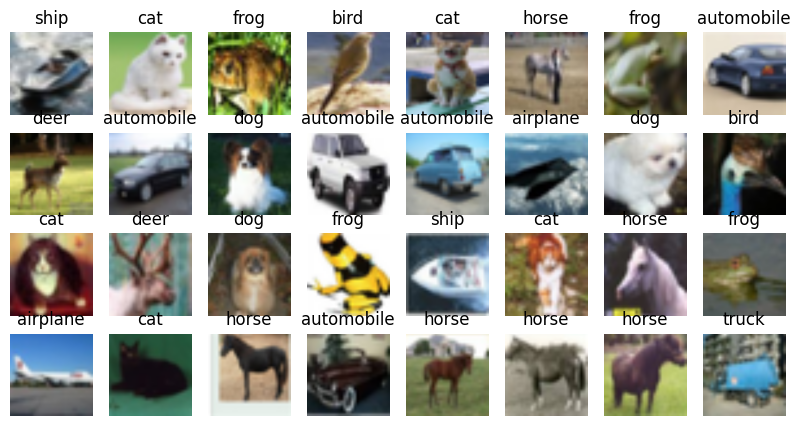

In [11]:
classes = trainset.classes

plt.figure(figsize=(10,5))

for X, y in train_datasets:
  for idx in range(32):
    plt.subplot(4, 8,idx+1)
    plt.imshow(X[idx].numpy().transpose((1,2,0)))
    plt.title(classes[int(y[idx])])
    plt.axis('off')
  break


#### optimizer, loss & metrics

In [12]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss      = torch.nn.CrossEntropyLoss()
metric    = lambda y_pred, y_true: (torch.argmax(y_pred, dim=1).type(y_true.dtype) == y_true).type(torch.float32).sum()

#### model train

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, "is available")

model.to(device);

cuda:0 is available


In [14]:
def train(model, optimizer, loss, metric, train_datasets, val_datasets, epochs = 1):

  train_datasets_length = len(train_datasets.dataset.targets)
  val_datasets_length   = len(val_datasets.dataset.targets)

  for epoch in range(epochs):
      model.train()

      train_loss = 0.0; train_accuracy = 0.0;
      for X, y in tqdm(train_datasets):
          X = X.to(device); y = y.to(device)

          y_pred = model(X)
          l = loss(y_pred, y)

          optimizer.zero_grad()
          l.backward()
          optimizer.step()

          train_loss     += l.item() * len(y)
          train_accuracy += metric(y_pred, y)

      model.eval()
      with torch.no_grad():
          val_loss = 0.0; val_accuracy = 0.0;
          for X, y in tqdm(val_datasets):
              X = X.to(device); y = y.to(device)

              y_pred = model(X)
              l = loss(y_pred, y)

              val_loss     += l.item() * len(y)
              val_accuracy += metric(y_pred, y)

          print("epoch: {}, train loss: {}, train accuracy: {}, val-loss: {}, val-accuracy: {}".format(
              epoch, train_loss / train_datasets_length, train_accuracy /  train_datasets_length,
              val_loss / val_datasets_length, val_accuracy / val_datasets_length)
              )

In [15]:
epochs = 10
train(model = model, optimizer = optimizer, loss = loss, metric=metric, train_datasets=train_datasets, val_datasets=val_datasets, epochs = epochs)

100%|██████████| 313/313 [00:17<00:00, 17.97it/s]


epoch: 0, train loss: 0.9969054852485657, train accuracy: 0.6517750024795532, val-loss: 0.694289942741394, val-accuracy: 0.7599999904632568


100%|██████████| 313/313 [00:15<00:00, 19.61it/s]


epoch: 1, train loss: 0.8283435569047928, train accuracy: 0.7131499648094177, val-loss: 0.6493467801094055, val-accuracy: 0.7752999663352966


100%|██████████| 313/313 [00:17<00:00, 18.37it/s]


epoch: 2, train loss: 0.791239022898674, train accuracy: 0.7281749844551086, val-loss: 0.6852281593322754, val-accuracy: 0.7597000002861023


100%|██████████| 313/313 [00:15<00:00, 19.66it/s]


epoch: 3, train loss: 0.768725870347023, train accuracy: 0.7357249855995178, val-loss: 0.6296801963806152, val-accuracy: 0.7871999740600586


100%|██████████| 313/313 [00:16<00:00, 19.17it/s]


epoch: 4, train loss: 0.7649643962144852, train accuracy: 0.7378999590873718, val-loss: 0.613024054813385, val-accuracy: 0.786300003528595


100%|██████████| 313/313 [00:15<00:00, 19.74it/s]


epoch: 5, train loss: 0.7458672418117523, train accuracy: 0.7421500086784363, val-loss: 0.6160749236106873, val-accuracy: 0.7836999893188477


100%|██████████| 313/313 [00:16<00:00, 19.23it/s]


epoch: 6, train loss: 0.7303355798125267, train accuracy: 0.748199999332428, val-loss: 0.5884712780952454, val-accuracy: 0.7989999651908875


100%|██████████| 313/313 [00:15<00:00, 19.60it/s]


epoch: 7, train loss: 0.7220323284864426, train accuracy: 0.7514249682426453, val-loss: 0.6142059161186219, val-accuracy: 0.7882999777793884


100%|██████████| 313/313 [00:16<00:00, 18.77it/s]


epoch: 8, train loss: 0.7156224979162216, train accuracy: 0.7544999718666077, val-loss: 0.5906900226116181, val-accuracy: 0.7947999835014343


100%|██████████| 313/313 [00:15<00:00, 19.69it/s]

epoch: 9, train loss: 0.7017796228408814, train accuracy: 0.7584249973297119, val-loss: 0.5981833331108093, val-accuracy: 0.7910999655723572


#### fine-tuning

In [16]:
# updating the base_model parameters
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

train(model = model, optimizer = optimizer, loss = loss, metric=metric, train_datasets=train_datasets, val_datasets=val_datasets, epochs = epochs)


100%|██████████| 313/313 [00:16<00:00, 19.50it/s]


epoch: 0, train loss: 0.8133325909376145, train accuracy: 0.7319499850273132, val-loss: 0.5587721879005432, val-accuracy: 0.8222999572753906


100%|██████████| 313/313 [00:16<00:00, 19.49it/s]


epoch: 1, train loss: 0.5805764536261558, train accuracy: 0.8134999871253967, val-loss: 0.5109943539619446, val-accuracy: 0.8278999924659729


100%|██████████| 313/313 [00:16<00:00, 19.52it/s]


epoch: 2, train loss: 0.5058170314311982, train accuracy: 0.8342750072479248, val-loss: 0.472598951625824, val-accuracy: 0.8411999940872192


100%|██████████| 313/313 [00:15<00:00, 19.56it/s]


epoch: 3, train loss: 0.46053637579083445, train accuracy: 0.8526749610900879, val-loss: 0.45468662316799163, val-accuracy: 0.8509999513626099


100%|██████████| 313/313 [00:16<00:00, 19.35it/s]


epoch: 4, train loss: 0.43542010974287987, train accuracy: 0.8617249727249146, val-loss: 0.4127970283985138, val-accuracy: 0.863599956035614


100%|██████████| 313/313 [00:18<00:00, 17.30it/s]


epoch: 5, train loss: 0.4049438627719879, train accuracy: 0.8705499768257141, val-loss: 0.3985308539509773, val-accuracy: 0.8671999573707581


100%|██████████| 313/313 [00:16<00:00, 19.43it/s]


epoch: 6, train loss: 0.37043778677284717, train accuracy: 0.8803249597549438, val-loss: 0.3965372066140175, val-accuracy: 0.8678999543190002


100%|██████████| 313/313 [00:16<00:00, 19.18it/s]


epoch: 7, train loss: 0.3601102297604084, train accuracy: 0.8851249814033508, val-loss: 0.38538937758803365, val-accuracy: 0.8727999925613403


100%|██████████| 313/313 [00:16<00:00, 19.21it/s]


epoch: 8, train loss: 0.32680188022255896, train accuracy: 0.8938249945640564, val-loss: 0.32523694469928743, val-accuracy: 0.8904999494552612


100%|██████████| 313/313 [00:16<00:00, 19.50it/s]

epoch: 9, train loss: 0.3071160009279847, train accuracy: 0.898099958896637, val-loss: 0.3112840692996979, val-accuracy: 0.8971999883651733


### evaluation

In [17]:
model.eval()
with torch.no_grad():
    test_loss = 0.0; test_accuracy = 0.0; test_datasets_length = len(test_datasets.dataset.targets)
    for X, y in tqdm(test_datasets):
        X = X.to(device); y = y.to(device)

        y_pred = model(X)
        l = loss(y_pred, y)

        test_loss     += l.item() * len(y)
        test_accuracy += metric(y_pred, y)

    print("\n test loss: {}, test accuracy: {}".format(test_loss / test_datasets_length, test_accuracy /  test_datasets_length))

100%|██████████| 313/313 [00:16<00:00, 19.38it/s]


 test loss: 0.324736097741127, test accuracy: 0.8959999680519104


#### plot the prediction

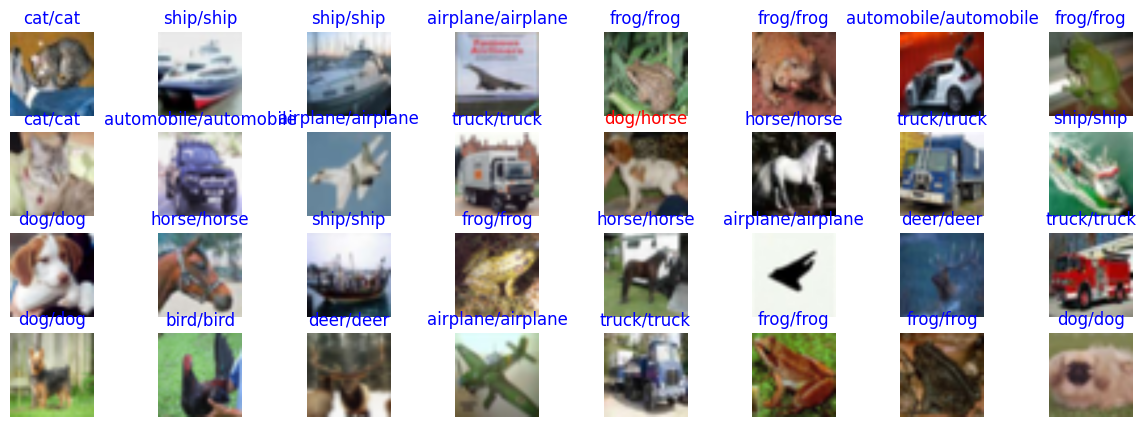

In [18]:
plt.figure(figsize=(15,5))

model.eval()
for X, y in test_datasets:
  X = X.to(device); y = y.to(device)
  y_pred = model(X)

  X = X.cpu();  y = y.cpu();  y_pred = y_pred.cpu().detach().numpy()
  for idx in range(32):
    plt.subplot(4, 8,idx+1)
    plt.imshow(X[idx].numpy().transpose((1,2,0)))
    y_pred_idx = int(np.argmax(y_pred[idx]))
    if int(y[idx]) == y_pred_idx:
      plt.title("{}/{}".format(classes[int(y[idx])], classes[y_pred_idx]), color = 'blue')
    else:
      plt.title("{}/{}".format(classes[int(y[idx])], classes[y_pred_idx]), color = 'red')
    plt.axis('off')
  break